In [1]:
!nvidia-smi

Wed Oct 22 11:34:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np
import time

Mnożenie macierzy CPU

In [3]:
# rozmiar macierzy
N = 1024

In [4]:
# Utworzenie dwóch losowych macierzy na CPU
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)

In [5]:
# Pomiar czasu dla operacji na CPU
start = time.time()
C_cpu = np.matmul(A_cpu, B_cpu)
end = time.time()

print(f"Mnożenie macierzy na CPU trwało: {end - start:.5f} sekund.")

Mnożenie macierzy na CPU trwało: 0.02004 sekund.


Mnożenie macierzy GPU

In [6]:
import cupy as cp

In [7]:
# przesłanie macierzy z CPU na GPU
A_gpu = cp.array(A_cpu)
B_gpu = cp.array(B_cpu)

In [9]:
# Pomiar czasu dla operacji na GPU
start = time.time()
C_gpu = cp.matmul(A_gpu, B_gpu)
cp.cuda.Stream.null.synchronize()
end = time.time()

print(f"Mnożenie macierzy na GPU trwało: {end - start:.5f} sekund.")

Mnożenie macierzy na GPU trwało: 0.00167 sekund.


KERNEL CUDA

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!pip install pycuda

In [12]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [13]:
# Kod kernela CUDA C++ jako string
kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < N && col < N) {
        float sum = 0.0;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""

# Kompilacja kernela
mod = SourceModule(kernel_code)

# Uzyskanie uchwytu do skompilowanej funkcji kernela
matrixMul = mod.get_function("matrixMul")

In [14]:
# Inicjalizacja pustej macierzy wynikowej
C_cpu = np.empty((N, N), dtype=np.float32)

In [15]:
# Alokacja pamięci na GPU dla każdej macierzy
A_gpu = cuda.mem_alloc(A_cpu.nbytes)
B_gpu = cuda.mem_alloc(B_cpu.nbytes)
C_gpu = cuda.mem_alloc(C_cpu.nbytes)

In [16]:
# Kopiowanie danych macierzy A i B z CPUna GPU
cuda.memcpy_htod(A_gpu, A_cpu)
cuda.memcpy_htod(B_gpu, B_cpu)

In [17]:
# Definicja rozmiaru bloku (ile wątków w bloku)
block_size = (32, 32, 1)

# Definicja rozmiaru siatki (ile bloków w siatce)
grid_size = (N // block_size[0], N // block_size[1], 1)

In [18]:
# Pomiar czasu i uruchomienie kernela na GPU
start = time.time()
matrixMul(
    A_gpu, B_gpu, C_gpu, np.int32(N),
    block=block_size,
    grid=grid_size
)

# Synchronizacja - czekamy, aż GPU zakończy obliczenia
cuda.Context.synchronize()
end = time.time()

print(f"Mnożenie macierzy na GPU (własny kernel) trwało: {end - start:.5f} sekund.")

Mnożenie macierzy na GPU (własny kernel) trwało: 0.00733 sekund.


In [19]:
# Pobranie wyników z GPU (Device) na CPU (Host)
cuda.memcpy_dtoh(C_cpu, C_gpu)

In [20]:
# zwolnienie pamięci na GPU
A_gpu.free()
B_gpu.free()
C_gpu.free()

Wykres


Rozpoczynam analizę wydajności...
Testuję dla N = 128...
Testuję dla N = 256...
Testuję dla N = 512...
Testuję dla N = 1024...
Testuję dla N = 2048...
Analiza zakończona.


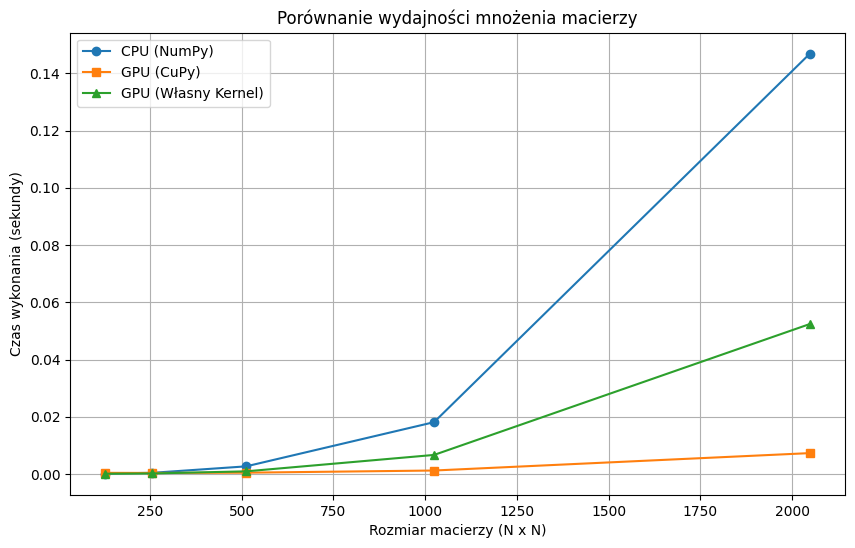

In [9]:
import numpy as np
import cupy as cp
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import time


kernel_code = """
__global__ void matrixMul(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}
"""
mod = SourceModule(kernel_code)
matrixMul_kernel = mod.get_function("matrixMul")

def run_cpu_test(A_cpu, B_cpu):
    start = time.time()
    np.matmul(A_cpu, B_cpu)
    end = time.time()
    return end - start

def run_cupy_test(A_cpu, B_cpu):
    A_gpu_cp = cp.array(A_cpu)
    B_gpu_cp = cp.array(B_cpu)
    start = time.time()
    cp.matmul(A_gpu_cp, B_gpu_cp)
    cp.cuda.Stream.null.synchronize()
    end = time.time()
    return end - start

def run_kernel_test(A_cpu, B_cpu):
    N = A_cpu.shape[0]
    C_cpu_empty = np.empty_like(A_cpu)

    A_gpu = cuda.mem_alloc(A_cpu.nbytes)
    B_gpu = cuda.mem_alloc(B_cpu.nbytes)
    C_gpu = cuda.mem_alloc(C_cpu_empty.nbytes)

    cuda.memcpy_htod(A_gpu, A_cpu)
    cuda.memcpy_htod(B_gpu, B_cpu)

    block_size = (32, 32, 1)
    grid_size = (int(np.ceil(N / block_size[0])), int(np.ceil(N / block_size[1])), 1)

    start = time.time()
    matrixMul_kernel(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
    cuda.Context.synchronize()
    end = time.time()

    A_gpu.free()
    B_gpu.free()
    C_gpu.free()
    return end - start

matrix_sizes = [128, 256, 512, 1024, 2048]
times_cpu, times_gpu_cupy, times_gpu_kernel = [], [], []

print("Rozpoczynam analizę wydajności...")
for N in matrix_sizes:
    print(f"Testuję dla N = {N}...")

    # Tworzenie macierzy dla danego rozmiaru N
    A = np.random.rand(N, N).astype(np.float32)
    B = np.random.rand(N, N).astype(np.float32)

    # Wywołanie funkcji testujących
    times_cpu.append(run_cpu_test(A, B))
    times_gpu_cupy.append(run_cupy_test(A, B))
    times_gpu_kernel.append(run_kernel_test(A, B))

print("Analiza zakończona.")

# Rysowanie wykresu (bez zmian)
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, times_cpu, 'o-', label='CPU (NumPy)')
plt.plot(matrix_sizes, times_gpu_cupy, 's-', label='GPU (CuPy)')
plt.plot(matrix_sizes, times_gpu_kernel, '^-', label='GPU (Własny Kernel)')
plt.xlabel('Rozmiar macierzy (N x N)')
plt.ylabel('Czas wykonania (sekundy)')
plt.title('Porównanie wydajności mnożenia macierzy')
plt.legend()
plt.grid(True)
plt.show()